In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

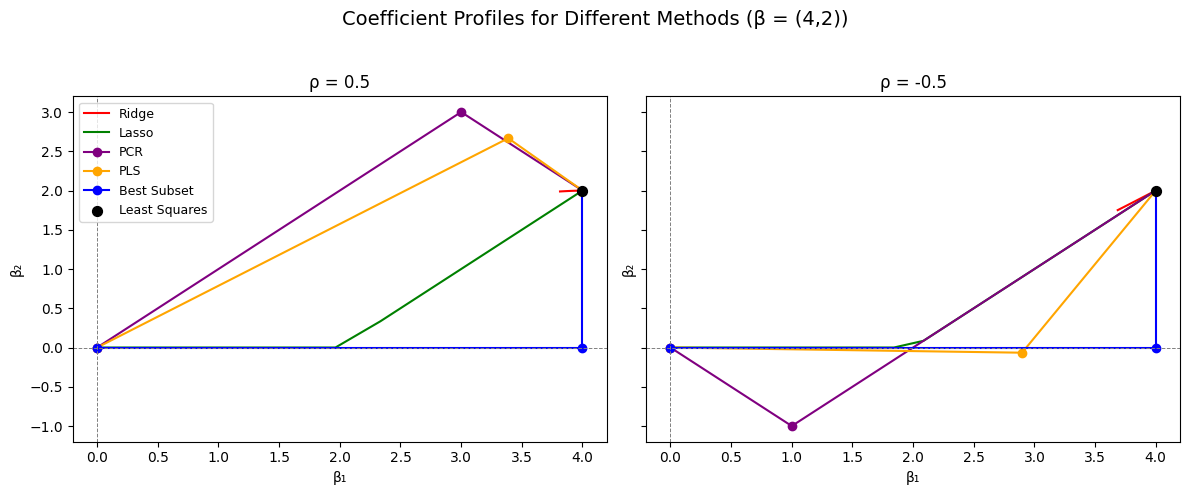

In [2]:
def simulate_data(rho, n=2000, beta_true=np.array([4.0, 2.0])):
    """
    شبیه‌سازی X ~ N(0, Σ) با Σ = [[1, rho], [rho, 1]]
    و y = X @ beta_true (بدون نویز).
    """
    cov = np.array([[1.0, rho],
                    [rho, 1.0]])
    X = np.random.multivariate_normal(mean=[0,0], cov=cov, size=n)
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    y = X.dot(beta_true)
    return X, y

def ridge_path(X, y, alphas):
    coefs = []
    for a in alphas:
        r = Ridge(alpha=a, fit_intercept=False)
        r.fit(X, y)
        coefs.append(r.coef_.copy())
    return np.array(coefs)

def lasso_path(X, y, alphas):
    coefs = []
    for a in alphas:
        l = Lasso(alpha=a, fit_intercept=False, max_iter=5000)
        l.fit(X, y)
        coefs.append(l.coef_.copy())
    return np.array(coefs)

def pcr_coeffs(X, y):
    ols = LinearRegression(fit_intercept=False).fit(X, y).coef_
    pca = PCA(n_components=1)
    Z1 = pca.fit_transform(X)     # (n,1)
    lr1 = LinearRegression(fit_intercept=False).fit(Z1, y)
    beta_pc1 = (pca.components_.T * lr1.coef_[0]).ravel()
    return np.vstack([beta_pc1, ols])

def pls_coeffs(X, y):
    """
    ضرایب PLS برای k=1 و k=2 مؤلفه.
    """
    ols = LinearRegression(fit_intercept=False).fit(X, y).coef_
    pls1 = PLSRegression(n_components=1, scale=False).fit(X, y)
    beta_pls1 = pls1.coef_.ravel()
    return np.vstack([beta_pls1, ols])

# تنظیمات
rhos  = [0.5, -0.5]
beta_true = np.array([4.0, 2.0])
alphas    = np.logspace(2, -3, 60)

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

for ax, rho in zip(axes, rhos):
    # شبیه‌سازی
    X, y = simulate_data(rho, n=2000, beta_true=beta_true)
    # مسیرها
    ridge_coefs = ridge_path(X, y, alphas)       # shape=(60,2)
    lasso_coefs = lasso_path(X, y, alphas)       # shape=(60,2)
    pcr_cs      = pcr_coeffs(X, y)               # shape=(2,2)
    pls_cs      = pls_coeffs(X, y)               # shape=(2,2)
    ols_beta    = pcr_cs[-1]                     # (2,)
    # مسیر Best Subset (ابتدا X1، سپس هر دو)
    bs1 = np.array([beta_true[0], 0.0])
    bs2 = beta_true.copy()

    # رسم
    ax.plot(ridge_coefs[:,0], ridge_coefs[:,1], color='red',    label='Ridge')
    ax.plot(lasso_coefs[:,0],lasso_coefs[:,1], color='green',  label='Lasso')
    ax.plot([0, pcr_cs[0,0], pcr_cs[1,0]],
            [0, pcr_cs[0,1], pcr_cs[1,1]],
            color='purple', linestyle='-', marker='o', label='PCR')
    ax.plot([0, pls_cs[0,0], pls_cs[1,0]],
            [0, pls_cs[0,1], pls_cs[1,1]],
            color='orange', linestyle='-', marker='o', label='PLS')
    ax.plot([0, bs1[0], bs2[0]],
            [0, bs1[1], bs2[1]],
            color='blue', linestyle='-', marker='o', label='Best Subset')
    ax.scatter([ols_beta[0]], [ols_beta[1]],
               color='black', s=50, zorder=10, label='Least Squares')

    # راهنما
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.set_title(f'ρ = {rho}')
    ax.set_xlabel(r'β₁')
    ax.set_ylabel(r'β₂')

axes[0].legend(loc='upper left', fontsize=9)
plt.suptitle('Coefficient Profiles for Different Methods (β = (4,2))', fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [3]:
df = pd.read_csv("/content/bank-sample.csv")
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,31,management,single,tertiary,no,0,yes,no,cellular,15,apr,185,2,-1,0,unknown,no
1,45,entrepreneur,married,tertiary,no,1752,yes,yes,cellular,20,nov,56,2,-1,0,unknown,no
2,46,services,divorced,secondary,no,4329,no,no,cellular,21,nov,534,2,-1,0,unknown,yes
3,35,management,married,tertiary,no,1108,yes,no,cellular,17,nov,52,1,-1,0,unknown,no
4,39,management,married,secondary,no,1410,yes,no,unknown,23,may,55,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,58,housemaid,married,tertiary,no,2858,no,no,cellular,31,jul,56,6,-1,0,unknown,no
1996,45,management,divorced,tertiary,no,220,yes,no,unknown,18,jun,89,4,-1,0,unknown,no
1997,45,unknown,married,primary,no,586,yes,no,telephone,21,jul,90,3,-1,0,unknown,no
1998,48,technician,married,secondary,no,178,yes,no,unknown,17,jun,320,4,-1,0,unknown,no


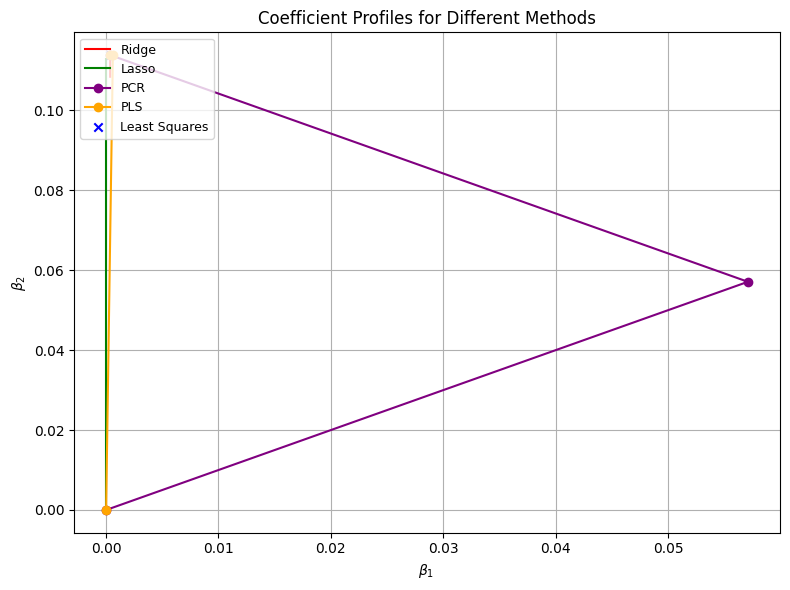

In [21]:
df = pd.read_csv("/content/bank-sample.csv")

X = df[['balance', 'duration']].dropna()
y = df.loc[X.index, 'subscribed'].map({'yes': 1, 'no': 0})

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

alphas = np.logspace(2, -3, 60)

def ridge_lasso_path(model, X, y, alphas):
    coefs = []
    for a in alphas:
        m = model(alpha=a, fit_intercept=False, max_iter=5000 if model is Lasso else None)
        m.fit(X, y)
        coefs.append(m.coef_.copy())
    return np.array(coefs)

def pcr_pls_coeffs(X, y):
    ols_model = LinearRegression(fit_intercept=False).fit(X, y)
    ols_coef = ols_model.coef_
    pca = PCA(n_components=1)
    Z = pca.fit_transform(X)
    lr = LinearRegression(fit_intercept=False).fit(Z, y)
    beta_pc1 = (pca.components_.T * lr.coef_[0]).ravel()
    pls = PLSRegression(n_components=1, scale=False).fit(X, y)
    beta_pls1 = pls.coef_.ravel()
    return beta_pc1, beta_pls1, ols_coef

# محاسبه
ridge_coefs = ridge_lasso_path(Ridge, X_scaled, y, alphas)
lasso_coefs = ridge_lasso_path(Lasso, X_scaled, y, alphas)
pcr_coef, pls_coef, ols_coef = pcr_pls_coeffs(X_scaled, y)

plt.figure(figsize=(8, 6))

plt.plot(ridge_coefs[:, 0], ridge_coefs[:, 1], color='red', label='Ridge')

plt.plot(lasso_coefs[:, 0], lasso_coefs[:, 1], color='green', label='Lasso')

plt.plot([0, pcr_coef[0], ols_coef[0]], [0, pcr_coef[1], ols_coef[1]], color='purple', linestyle='-', marker='o', label='PCR')

plt.plot([0, pls_coef[0], ols_coef[0]], [0, pls_coef[1], ols_coef[1]], color='orange', linestyle='-', marker='o', label='PLS')

# رسم ضرایب OLS به صورت یک نقطه (چون مسیر ندارد)
plt.scatter(ols_coef[0], ols_coef[1], color='blue', marker='x', label='Least Squares')

plt.title('Coefficient Profiles for Different Methods')
plt.xlabel(r'$\beta_1$ ')
plt.ylabel(r'$\beta_2$ ')
plt.legend(loc='upper left', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
df = pd.read_csv('/content/data ua..uc.csv')

df.head()


,tashkhs,BLOOD,NITRIT,MUSUS,BACTER,EP.clearE,RBC,PH,S.G,APP,COL,A,S,wbc,N,COLONY COUNT,id
0,NO,f,n,N,clear,f,0-2,5.0,1030.0,C,Y,7.0,M,0-2,2089.0,1000.0,1.0
1,NO,f,n,N,clear,f,2-5,5.0,1030.0,C,Y,54.0,F,2-3,2090.0,1000.0,2.0
2,NO,clear,n,N,clear,f,10-25,6.0,1030.0,H,Y,78.0,M,0-2,2091.0,1000.0,3.0
3,NO,clear,n,N,clear,f,0-2,5.0,1030.0,C,Y,36.0,F,0-2,2100.0,1000.0,4.0
4,NO,f,n,P,mod,mod,0-2,5.0,1030.0,H,Y,26.0,F,2-3,2103.0,1000.0,5.0


In [6]:
df.columns

Index(['tashkhs', 'BLOOD', 'NITRIT', 'MUSUS', 'BACTER', 'EP.clearE', 'RBC',
       'PH', 'S.G', 'APP', 'COL', 'A', 'S', 'wbc', 'N', 'COLONY COUNT', 'id'],
      dtype='object')

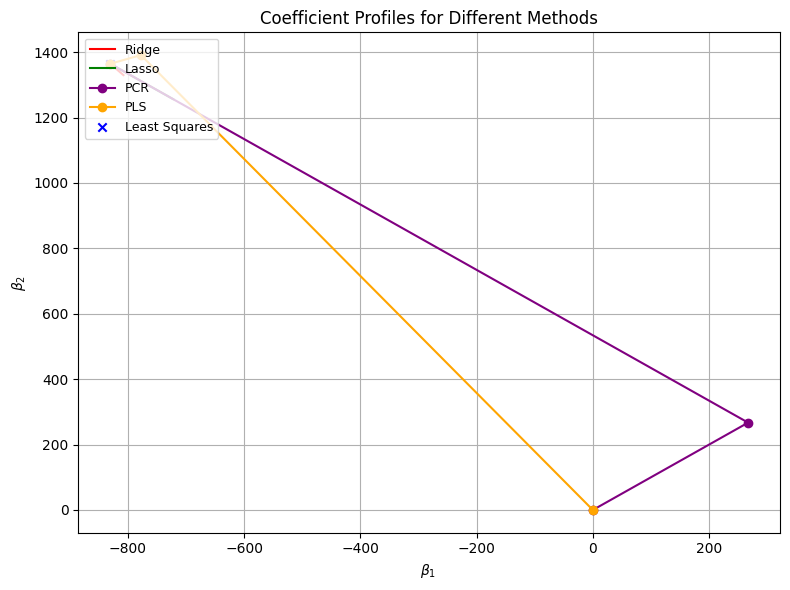

In [20]:
df = pd.read_csv('/content/data ua..uc.csv')

X = df[['N', 'S.G']].dropna()
y = df.loc[X.index, 'COLONY COUNT']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

alphas = np.logspace(2, -3, 60)


# محاسبه
ridge_coefs = ridge_lasso_path(Ridge, X_scaled, y, alphas)
lasso_coefs = ridge_lasso_path(Lasso, X_scaled, y, alphas)
pcr_coef, pls_coef, ols_coef = pcr_pls_coeffs(X_scaled, y)

plt.figure(figsize=(8, 6))

plt.plot(ridge_coefs[:, 0], ridge_coefs[:, 1], color='red', label='Ridge')

plt.plot(lasso_coefs[:, 0], lasso_coefs[:, 1], color='green', label='Lasso')

plt.plot([0, pcr_coef[0], ols_coef[0]], [0, pcr_coef[1], ols_coef[1]], color='purple', linestyle='-', marker='o', label='PCR')

plt.plot([0, pls_coef[0], ols_coef[0]], [0, pls_coef[1], ols_coef[1]], color='orange', linestyle='-', marker='o', label='PLS')

# رسم ضرایب OLS به صورت یک نقطه (چون مسیر ندارد)
plt.scatter(ols_coef[0], ols_coef[1], color='blue', marker='x', label='Least Squares')

plt.title('Coefficient Profiles for Different Methods')
plt.xlabel(r'$\beta_1$ ')
plt.ylabel(r'$\beta_2$ ')
plt.legend(loc='upper left', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
df = pd.read_csv('/content/Airlines Delay Data.csv')
df

,ID,Flight,Time,Length,BaggageTime,DayOfWeek,AiportOrigin,AirportDestination,AirlineNames,Class,Airline,AirportFrom,AirportTo
0,1,2313,1296,141,45,1,17,130,6,0,DL,ATL,HOU
1,2,6948,360,146,56,4,66,209,13,0,OO,COS,ORD
2,3,1247,1170,143,39,3,36,61,4,0,B6,BOS,CLT
3,4,31,1410,344,49,6,204,218,15,0,US,OGG,PHX
4,5,563,692,98,54,4,33,17,9,0,FL,BMI,ATL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
539377,539378,6973,530,72,47,5,112,253,13,1,OO,GEG,SEA
539378,539379,1264,560,115,37,4,154,80,16,1,WN,LAS,DEN
539379,539380,5209,827,74,49,2,48,17,7,1,EV,CAE,ATL
539380,539381,607,715,65,35,4,46,44,16,1,WN,BWI,BUF


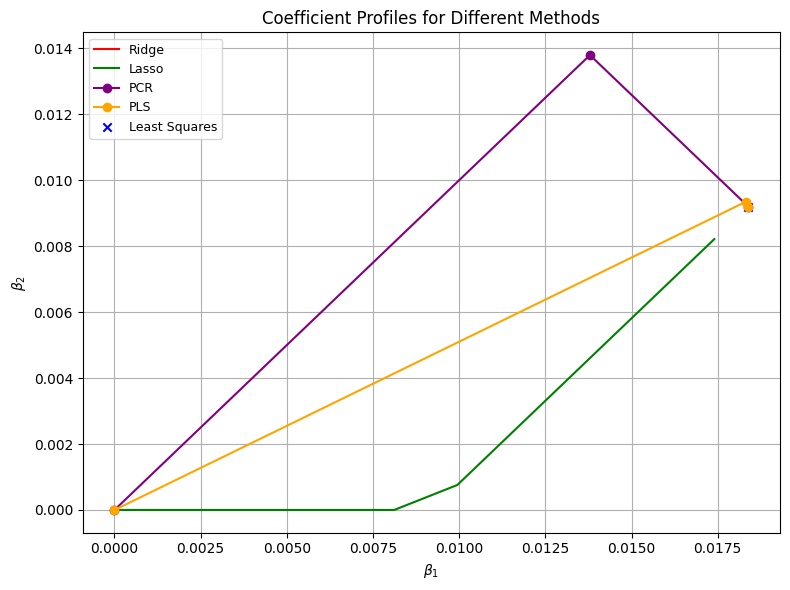

In [19]:
df = pd.read_csv('/content/Airlines Delay Data.csv')

# انتخاب دو ویژگی عددی و هدف
X = df[['Length', 'DayOfWeek']].dropna()
y = df.loc[X.index, 'BaggageTime']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

alphas = np.logspace(2, -3, 60)


# محاسبه
ridge_coefs = ridge_lasso_path(Ridge, X_scaled, y, alphas)
lasso_coefs = ridge_lasso_path(Lasso, X_scaled, y, alphas)
pcr_coef, pls_coef, ols_coef = pcr_pls_coeffs(X_scaled, y)

plt.figure(figsize=(8, 6))

plt.plot(ridge_coefs[:, 0], ridge_coefs[:, 1], color='red', label='Ridge')

plt.plot(lasso_coefs[:, 0], lasso_coefs[:, 1], color='green', label='Lasso')

plt.plot([0, pcr_coef[0], ols_coef[0]], [0, pcr_coef[1], ols_coef[1]], color='purple', linestyle='-', marker='o', label='PCR')

plt.plot([0, pls_coef[0], ols_coef[0]], [0, pls_coef[1], ols_coef[1]], color='orange', linestyle='-', marker='o', label='PLS')

# رسم ضرایب OLS به صورت یک نقطه (چون مسیر ندارد)
plt.scatter(ols_coef[0], ols_coef[1], color='blue', marker='x', label='Least Squares')

plt.title('Coefficient Profiles for Different Methods')
plt.xlabel(r'$\beta_1$ ')
plt.ylabel(r'$\beta_2$ ')
plt.legend(loc='upper left', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()